## Predicting Missing links in a citation network

In [1]:
# global imports 
import random 
import numpy as np 
import pandas as pd
import jgraph ## this was previously known as igraph
import csv 
import matplotlib.pyplot as plt

# machine learning imports
from sklearn import svm 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel 
from sklearn import preprocessing 

import spacy

### Import datasets

In [4]:
# function to read data from txt files
nodes_info_df = pd.read_csv('./data/node_information.csv')
random_preds_df = pd.read_csv('./data/random_predictions.csv') 
test_set = pd.read_csv('./data/testing_set.txt', sep = ' ', header = None)
train_set = pd.read_csv('./data/training_set.txt', sep = ' ', header = None)
test_set.columns = ['source_id', 'target_id']
train_set.columns = ['source_id', 'target_id', 'label']
nodes_info_df.columns = ['paper_id', 'publication_year', 'title', 'author', 'journal_name', 'abstract']

## Exploratory Analysis

In [5]:
print('Unique papers: ', len(set(nodes_info_df['paper_id'])))
sym_diff = set(test_set['source_id'].append(test_set['target_id'])).symmetric_difference(set(nodes_info_df['paper_id']))
print('Unknown papers in test set (with nodes_info):', len(sym_diff))

Unique papers:  27769
Unknown papers in test set (with nodes_info): 4369


In [6]:
# # get distribution of journal names 
# nodes_info_df['journal_name'] = nodes_info_df['journal_name'].fillna('unknown')
# nodes_info_df.journal_name.value_counts()[:15]

In [7]:
# nodes_info_df.author

## Feature generation

### Text features generation 

In [8]:
import re 
import math

def isNaN(string):
    return string != string

def filter_bad(alphabet):
    bad = [',', None]

    if(alphabet in bad):
        return False
    else:
        return True
    
## possible formats of authors:
# several authors: separation via ','
# sometimes mentions the university eg '(montpellier)'
# sometimes mentions the first name 
# sometimes format is: firstname letter. lastname
def author_normalisation(authors):
    if isNaN(authors) == False:
        #print(authors)
        authors = authors.lower()
        final_authors = list()
        
        # remove universities and last space
        if '(' in authors:
            authors = re.sub(r'\(+.*\)', '', authors).strip() 
        
        # remove extra spaces
        authors = authors.split()
        authors = ' '.join(filter(filter_bad, authors))
          
        # get all authors of one paper 
        for author in authors.split(', '): 
            author.strip()            
            # get the names of an author
            names = author.split(' ')
            author_names = list()        
            if len(names) == 2:
                # check if first element is 'letter.' format:
                if re.match('\w\.', names[0]):
                    author_names.append(names[0])
                else:
                    author_names.append(names[0][0] + '.')

            if len(names) == 3:
                if re.match('\w\.', names[0]):
                    author_names.append(names[0])
                else:
                    author_names.append(names[0][0] + '.')

                # skip the second middle name
                if re.match('\w\.', names[1]):
                    pass
                    #author_names.append(names[1])
                #else:
                #    author_names.append(names[1][0] + '.')

            author_names.append(names[-1])
            if len(author_names) > 1:
                author_names = ' '.join(author_names)
            else:
                author_names = author_names[0]
            # append last name
            final_authors.append(author_names)


        number_of_authors = len(final_authors)
        if number_of_authors == 0:
            return np.NaN
        return final_authors
    
    return np.NaN

def common_authors(string1, string2):
    if isNaN(string1):
        return False
    if isNaN(string2):
        return False
    
    #a_set = set(string1.split(','))
    #b_set = set(string2.split(','))
    a_set = set(string1)
    b_set = set(string2)
    
    if (a_set & b_set): 
        return True 
    else: 
        return False
    
def number_common_authors(string1, string2):
    pass


In [9]:
# reaye source and target info datasets
train_source_info = train_set.merge(nodes_info_df, left_on='source_id', right_on='paper_id')
train_target_info = train_set.merge(nodes_info_df, left_on='target_id', right_on='paper_id')

test_source_info = test_set.merge(nodes_info_df, left_on='source_id', right_on='paper_id')
test_target_info = test_set.merge(nodes_info_df, left_on='target_id', right_on='paper_id')


In [10]:
## apply the features to training set 
train_set['source_authors'] = train_source_info.author.apply(lambda x: author_normalisation(x))
train_set['target_authors'] = train_target_info.author.apply(lambda x: author_normalisation(x))

train_set['publication_year_diff'] = train_source_info.publication_year - train_target_info.publication_year

train_set['source_journal'] = train_source_info.journal_name
train_set['target_journal'] = train_target_info.journal_name

train_set['same_journal'] = train_set.apply(lambda x: int(x.source_journal == x.target_journal), axis=1)

## apply the features to test set
test_set['source_authors'] = test_source_info.author.apply(lambda x: author_normalisation(x))
test_set['target_authors'] = test_target_info.author.apply(lambda x: author_normalisation(x))

test_set['publication_year_diff'] = test_source_info.publication_year - test_target_info.publication_year

test_set['source_journal'] = test_source_info.journal_name
test_set['target_journal'] = test_target_info.journal_name
test_set['same_journal'] = test_set.apply(lambda x: int(x.source_journal == x.target_journal), axis=1)


### Graph features generation 

In [12]:
import networkx as nx 
# get some elements and then assign the attributes -> this is shite so ignore it 
def shortest_path_info(some_graph, source, target):
    if source not in some_graph.nodes():
        return -1 # not known 
    if target not in some_graph.nodes():
        return -1 # not known 
    if nx.has_path(some_graph, source, target):
        return nx.dijkstra_path_length(some_graph, source=source, target=target)
    
    return -2 # no path

def degree_centrality(some_graph):
    degree_dict = dict(some_graph.degree(some_graph.nodes()))
    return degree_dict

def get_in_out_degree(some_graph):
    in_degree_dict = dict(some_graph.in_degree(some_graph.nodes()))
    out_degree_dict = dict(some_graph.out_degree(some_graph.nodes()))
    return in_degree_dict, out_degree_dict
    

def common_neighs(some_graph, x, y):
    if x not in some_graph.nodes():
        return 0,[] # not known 
    if y not in some_graph.nodes():
        return 0,[] # not known
    neighs = sorted(list(nx.common_neighbors(some_graph, x, y)))
    return len(neighs), neighs

def jac_index(g, x, y):
    if x not in g.nodes():
        return -1 # not known 
    if y not in g.nodes():
        return -1 # not known
    preds = nx.jaccard_coefficient(g, [(x, y)])
    jacc = 0

    for u, v, p in preds:
        jacc = p
    return jacc

def pref_attachement(g, x, y):
    if x not in g.nodes():
        return -1 # not known 
    if y not in g.nodes():
        return -1 # not known
    preds = nx.preferential_attachment(g, [(x, y)])
    pref = 0

    for u, v, p in preds:
        pref = p
    return pref

def aa_index(g, x, y):
    if x not in g.nodes():
        return -1 # not known 
    if y not in g.nodes():
        return -1 # not known
    preds = nx.adamic_adar_index(g, [(x, y)])
    aa = 0

    for u, v, p in preds:
        aa = p
    return aa

In [15]:
# create the network 
# get network for when there is a connection in train set
# edges = list(zip(train_set.loc[train_set.label == 1].source_id, train_set.loc[train_set.label == 1].target_id))
# nodes = list(set(train_set.source_id + train_set.target_id))

# train_G = nx.DiGraph()
# train_G.add_nodes_from(nodes)
# train_G.add_edges_from(edges)

train_G = nx.from_pandas_edgelist(train_set, source='source_id', target='target_id', edge_attr=None,
                                  create_using=nx.DiGraph())

# make sure you also have an undirected graph
train_G_ud = train_G.to_undirected()

# create some dictionaries to use later on
clustering_coeff_dict = nx.clustering(train_G_ud)
avg_neigh_degree_dict = nx.average_neighbor_degree(train_G)
out_degree_centrality = nx.out_degree_centrality(train_G)
in_degree_centrality = nx.in_degree_centrality(train_G)
page_rank = nx.pagerank_scipy(train_G)
hub_score, authority_score = nx.hits(train_G)

In [21]:
# function to get features for graph of a single element
def get_features(directed_graph, ud_graph, source_id, target_id, label):
    # features for undirected graph
    jaccard_index = jac_index(ud_graph, source_id, target_id)
    preferencial_attachment = pref_attachement(ud_graph, source_id, target_id)
    number_common_neighbours, common_neighbours = common_neighs(ud_graph, source_id, target_id)
    adamic_adar_index = aa_index(ud_graph, source_id, target_id)
    #shortest_path = shortest_path_info(train_G, source_id, target_id)

    
    source_pr = page_rank[source_id]
    source_hub_score = hub_score[source_id]
    source_authority_score = authority_score[source_id]
    source_cluster_coeff = clustering_coeff_dict[source_id]
    source_out_centrality = out_degree_centrality[source_id]
    source_avg_neigh_degree = avg_neigh_degree_dict[source_id]
 
    target_pr = page_rank[target_id]
    target_hub_score = hub_score[target_id]
    target_authority_score = authority_score[target_id]
    target_cluster_coeff = clustering_coeff_dict[target_id]
    target_in_centrality = in_degree_centrality[target_id]
    target_avg_neigh_degree = avg_neigh_degree_dict[target_id]

    # no name feature but supposedly important 
    feature_n = source_out_centrality * target_in_centrality
     
    return [source_id, target_id, label, jaccard_index, preferencial_attachment, 
            number_common_neighbours, adamic_adar_index, source_pr, target_pr, 
            source_hub_score, target_hub_score, source_authority_score, 
            target_authority_score, source_cluster_coeff, target_cluster_coeff, 
            source_out_centrality, target_in_centrality, source_avg_neigh_degree, 
            target_avg_neigh_degree, feature_n]
    

### IMPORTANT: add column names when adding new features to the dataset 

In [22]:
### add columns when you add Features
column_names = ['source_id', 'target_id', 'label', 'jaccard_index', 'preferential_attachement', 
                'number_common_neighbours',  'adamic_adar_index', 'source_pr',
                'target_pr', 'source_hub_score', 'target_hub_score', 'source_authority_score',
                'target_authority_score', 'source_cluster_coeff', 'target_cluster_coeff',
                'source_out_centrality', 'target_in_centrality', 'source_avg_neigh_degree', 
                'target_avg_neigh_degree', 'feature_n']
final_train_set = pd.DataFrame([[np.nan]*len(column_names)]* train_set.shape[0], columns=column_names)
final_test_set = pd.DataFrame([[np.nan]*len(column_names)]* test_set.shape[0], columns=column_names)

In [23]:
# create the features for the train set
for idx, row in train_set.iterrows():
    features = get_features(train_G, train_G_ud, row.source_id, row.target_id, row.label)
    #update the features
    final_train_set.loc[idx] = features

In [24]:
#create the features for the test set
for idx, row in test_set.iterrows():
    features = get_features(train_G, train_G_ud, row.source_id, row.target_id, -1)
    #update the features
    final_test_set.loc[idx] = features

In [25]:
# merge graph and text features together 
train_set = train_set.merge(final_train_set, on=['source_id', 'target_id', 'label'], how='left') 
test_set = test_set.merge(final_test_set, on=['source_id', 'target_id'], how='left')

In [26]:
# write out so that you do not have to run everything again
train_set.to_csv('final_train.csv',index=False)
test_set.to_csv('final_test.csv', index=False)

### Can start from here as well when features were saved previously

In [2]:
test_set = pd.read_csv('final_test.csv')
train_set = pd.read_csv('final_train.csv')

### Final clean (i.e replacing nans etc)

In [3]:
# fill nas in some way
train_set.publication_year_diff.fillna(-24, inplace=True) # 24 is for unknown (?)
train_set.fillna('unknown', inplace=True)

test_set.publication_year_diff.fillna(-24, inplace=True) # 24 is for unknown (?_)
test_set.fillna('unknown', inplace=True)

0         0
1         0
2         0
3         0
4         0
         ..
615507    0
615508    0
615509    0
615510    0
615511    0
Name: number_common_authors, Length: 615512, dtype: int64

In [28]:
test_set.head()

,source_id,target_id,source_authors,target_authors,number_common_authors,publication_year_diff,source_journal,target_journal,same_journal,label,...,target_hub_score,source_authority_score,target_authority_score,source_cluster_coeff,target_cluster_coeff,source_out_centrality,target_in_centrality,source_avg_neigh_degree,target_avg_neigh_degree,feature_n
0,9807076,9807139,"[s. kachru, j. kumar, e. silverstein]","[j. lu, s. roy]",0,0.0,Phys.Rev.,Phys.Lett.,0,-1.0,...,0.000036,0.000146,0.000005,0.087579,0.098151,0.000648,0.000432,23.277778,27.615385,2.801130e-07
1,109162,1182,"[s. kachru, j. kumar, e. silverstein]","[j. lu, s. roy]",0,0.0,Phys.Rev.,Phys.Lett.,0,-1.0,...,0.000021,0.000088,0.000048,0.067997,0.193548,0.007778,0.001729,35.430556,28.071429,1.344542e-05
2,9702187,9510135,"[s. kachru, j. kumar, e. silverstein]","[h. grosse, t. krajewski, r. wulkenhaar]",0,-2.0,Phys.Rev.,unknown,0,-1.0,...,0.000102,0.000738,0.002486,0.058951,0.025157,0.000936,0.026540,24.461538,21.300000,2.484965e-05
3,111048,110115,[r. szabo],"[h. grosse, t. krajewski, r. wulkenhaar]",0,1.0,unknown,unknown,0,-1.0,...,0.000073,0.000021,0.000043,0.173677,0.141997,0.001729,0.001008,34.416667,38.392857,1.742925e-06
4,9910176,9410073,[r. szabo],"[h. grosse, t. krajewski, r. wulkenhaar]",0,1.0,unknown,unknown,0,-1.0,...,0.000011,0.000022,0.000503,0.016667,0.043384,0.000504,0.005582,19.571429,21.882353,2.814098e-06


In [29]:
train_set.head()

,source_id,target_id,label,source_authors,target_authors,number_common_authors,publication_year_diff,source_journal,target_journal,same_journal,...,target_hub_score,source_authority_score,target_authority_score,source_cluster_coeff,target_cluster_coeff,source_out_centrality,target_in_centrality,source_avg_neigh_degree,target_avg_neigh_degree,feature_n
0,9510123,9502114,1,unknown,"[w. kim, j. lee, y. park]",0,0.0,Phys.Lett.,Phys.Lett.,1,...,5.928285e-07,0.000018,0.000012,0.007905,0.008547,0.000324,0.000720,20.777778,18.285714,2.334275e-07
1,9707075,9604178,1,unknown,"[w. kim, j. lee, y. park]",0,0.0,Phys.Lett.,Phys.Lett.,1,...,9.071772e-05,0.000050,0.000371,0.166022,0.125799,0.002701,0.004754,32.480000,26.025000,1.283851e-05
2,9312155,9506142,0,unknown,"[w. kim, j. lee, y. park]",0,0.0,Phys.Lett.,Phys.Lett.,1,...,2.375408e-06,0.000003,0.000002,0.006536,0.008658,0.000288,0.000288,26.125000,21.214286,8.299645e-08
3,9911255,302165,0,unknown,"[w. kim, j. lee, y. park]",0,0.0,Phys.Lett.,Phys.Lett.,1,...,1.170214e-05,0.000030,0.000017,0.138138,0.081439,0.000972,0.000432,21.851852,29.000000,4.201695e-07
4,9701033,209076,0,unknown,"[w. kim, j. lee, y. park]",0,0.0,Phys.Lett.,Phys.Lett.,1,...,1.728026e-05,0.000012,0.000014,0.016043,0.104533,0.000648,0.000432,28.444444,28.400000,2.801130e-07


In [1]:
# check the types of each column (none should be object)
train_set.dtypes

NameError: name 'train_set' is not defined

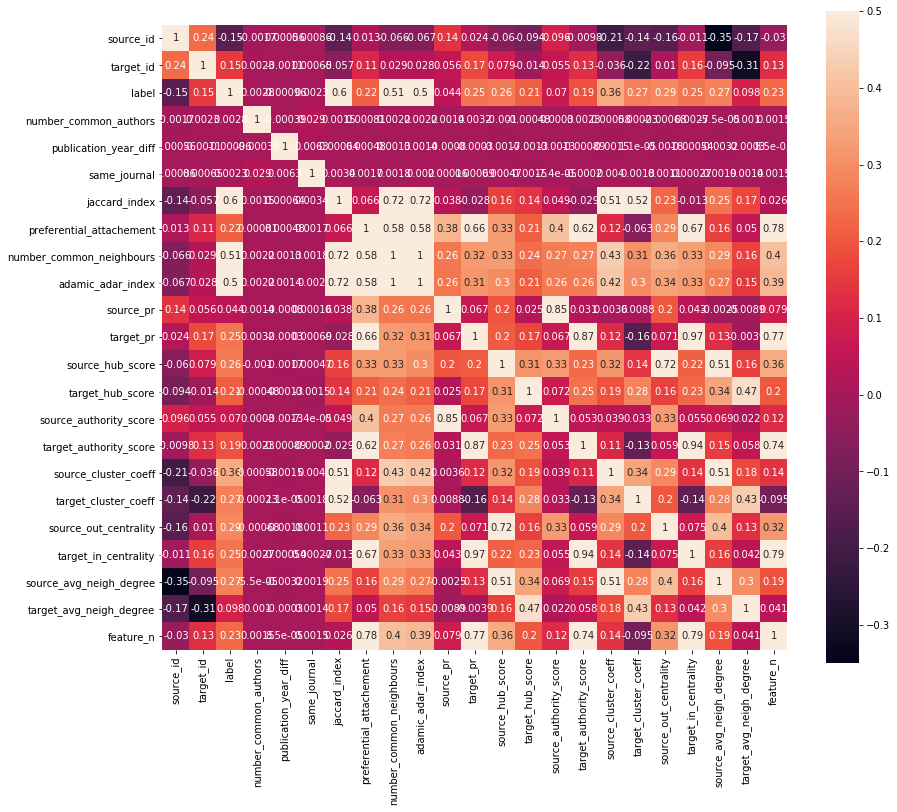

In [11]:
%matplotlib inline
## Most interesting correlation is with label
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,12))
sns.heatmap(train_set.corr(),
            vmax=0.5,
            square=True,
            annot=True)


## Learning Stuff

In [5]:
# separate features from labels:
X = train_set.loc[:, (train_set.columns != 'label') & 
                  (train_set.columns != 'common_authors') & 
                  (train_set.columns != 'source_authors') & 
                  (train_set.columns != 'target_authors') & 
                  (train_set.columns != 'source_journal') & 
                  (train_set.columns != 'target_journal') 
                 ]
y = train_set['label']
y.astype(np.int)


0         1
1         1
2         0
3         0
4         0
         ..
615507    1
615508    0
615509    0
615510    1
615511    1
Name: label, Length: 615512, dtype: int64

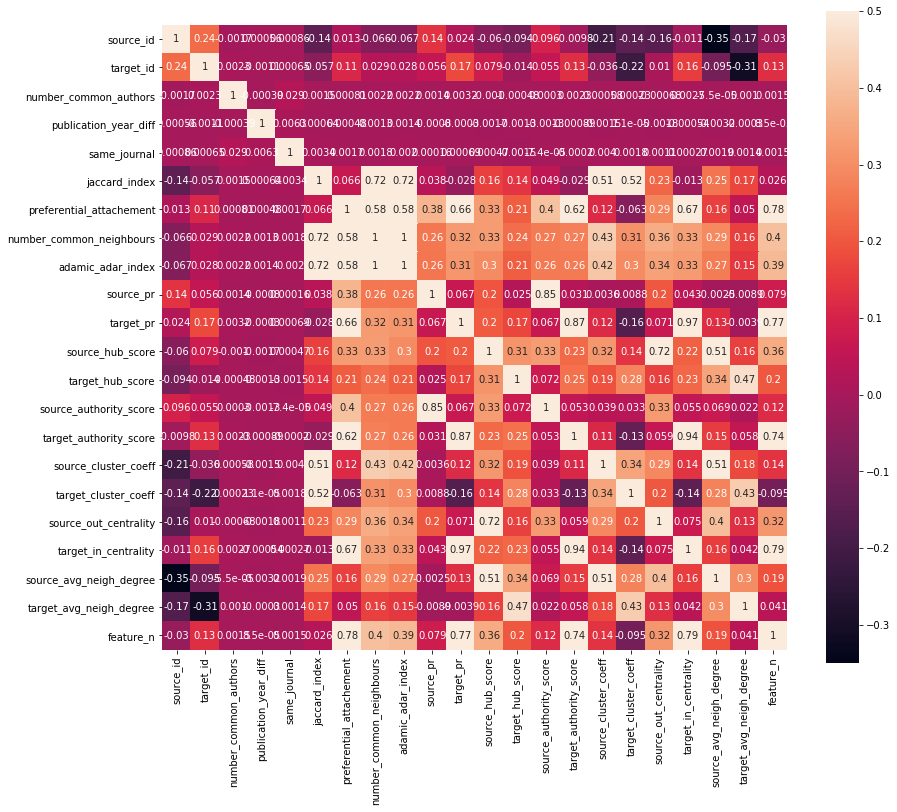

In [12]:
# final feature correlation
ff = X.copy()
ff['label'] = y
plt.figure(figsize=(14,12))
sns.heatmap(X.corr(),
            vmax=0.5,
            square=True,
            annot=True)

In [8]:
## Train different models and compare the performance 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import  f1_score, confusion_matrix
from sklearn.model_selection import cross_validate

model = AdaBoostClassifier(n_estimators=75, learning_rate=1)
scores = cross_validate(model, X, y, scoring='f1', 
                        cv=10) # n_jobs is the number of cpus to use -1 => all
scores

{'fit_time': array([176.49209499, 126.96805596, 106.90223503,  98.49411964,
        115.91014886, 118.42376113, 113.67929029, 110.60712481,
        118.56389689, 117.4148128 ]),
 'score_time': array([1.00028944, 1.0786097 , 1.03681803, 1.02636504, 1.0270772 ,
        0.77857327, 1.06426549, 0.89098072, 1.06391668, 1.0795002 ]),
 'test_score': array([0.95543953, 0.95432689, 0.95485711, 0.95413318, 0.95396905,
        0.95371115, 0.95568535, 0.95433908, 0.95387793, 0.95436945])}

In [10]:
# describe results from scores
from scipy import stats 
stats.describe(scores['test_score'])

DescribeResult(nobs=10, minmax=(0.9537111539570966, 0.9556853523477206), mean=0.9544708719147975, variance=4.3393884483164826e-07, skewness=0.7947367347642024, kurtosis=-0.6317507457312379)

### Recursive feature selection 

In [9]:
# ## ONLY RUN AT THE END FOR GRAPHS.. takes a v.long time to execute (been 3hours for now.. only execute on a virtual 
# # machine with GPUs (if possible))
# from sklearn.feature_selection import RFECV

# clf_rf_4 = model
# rfecv = RFECV(estimator=clf_rf_4, step=1, cv=10,scoring='f1')   #10-fold cross-validation
# rfecv = rfecv.fit(X, y)

# print('Optimal number of features :', rfecv.n_features_)
# print('Best features :', X.columns[rfecv.support_])

In [ ]:
# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## prior to authors:
DescribeResult(nobs=10, minmax=(0.7092423428264374, 0.7505859928392963), mean=0.7330286516063008, variance=0.0002449243278408503, skewness=-0.16892931758355367, kurtosis=-1.5003847605685021)

after some basic graphs:
DescribeResult(nobs=10, minmax=(0.9537111539570966, 0.9556853523477206), mean=0.9544708719147975, variance=4.3393884483164826e-07, skewness=0.7947367347642024, kurtosis=-0.6317507457312379)

### Predicting using final model 

In [29]:
from sklearn.ensemble import AdaBoostClassifier
# 1: retrain the complete model -> don't forget to change this to optimal one @ end
final_model = AdaBoostClassifier(n_estimators=75, learning_rate=1)
final_model.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=75, random_state=None)

In [43]:
# 2: predict on the test set
final_test_set = test_set.loc[:, (test_set.columns != 'source_authors') & (test_set.columns != 'common_authors') & (test_set.columns != 'target_authors')& (test_set.columns != 'label')]
predictions = final_model.predict(final_test_set)

# write out
out_df = test_set.copy()
data = {'id': list(out_df.index), 'category': predictions}
final_df = pd.DataFrame(data)


# 3: write file out
final_df.to_csv('submission.csv',index=False, sep=',')

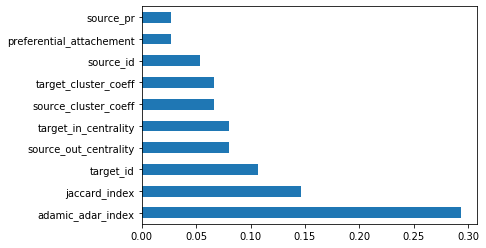

In [30]:
# plot the feature importance
feat_importances = pd.Series(final_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## The end